# Inspect data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# root = '/kaggle/input/linking-writing-processes-to-writing-quality/'
root = 'data/'

# load the data into pandas dataframes
scores = pd.read_csv(root + 'train_scores.csv')
train = pd.read_csv(root + 'train_logs.csv')
test = pd.read_csv(root + 'test_logs.csv')
sample = pd.read_csv(root + 'sample_submission.csv')

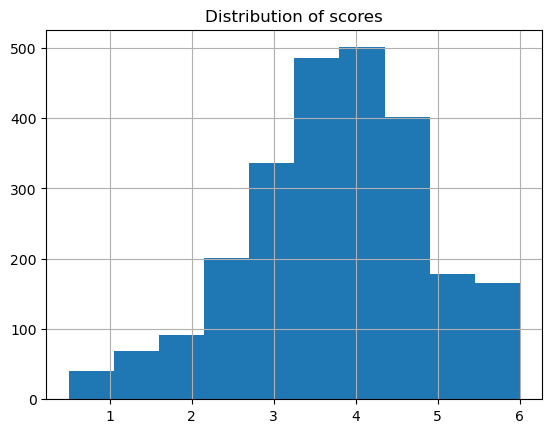

In [7]:
plt.title('Distribution of scores')
scores['score'].hist();

In [8]:
scores['score'].describe()

count    2471.000000
mean        3.711251
std         1.024937
min         0.500000
25%         3.000000
50%         4.000000
75%         4.500000
max         6.000000
Name: score, dtype: float64

- Min score of 0.5, max of 6

In [9]:
train.id.nunique()

2471

- 2471 total writers

# Create feature df

In [3]:
# function to convert logs to a features df

def create_features_dataframe(df):
    # If activity column contains 'Move', set that value to 'Move'
    df.loc[df['activity'].str.contains('Move', na=False), 'activity'] = 'Move'

    # Group users by id
    grouped = df.groupby('id')

    # Calculate summary statistics for each user
    features = grouped.agg({
        'down_time': ['sum', 'mean', 'std', 'min', 'max'], 
        'up_time': ['sum', 'mean', 'std', 'min', 'max'],    
        'action_time': ['sum', 'mean', 'std', 'min', 'max'],
        'id': 'count'                                       
    })

    # Flatten the multi-level columns
    features.columns = ['_'.join(col).strip() for col in features.columns.values]

    # Reset index to make 'id' a column again
    features.reset_index(inplace=True)

    # Rename 'id_count' to 'tot_actions'
    features = features.rename(columns={"id_count": "tot_actions"})

    # Group by user and take the last 'word_count' value
    last_word_count = df.groupby('id')['word_count'].last().reset_index()

    # Add to features dataframe
    features = features.merge(last_word_count, on='id', how='left')

    # Add column 'keys_per_word' by dividing 'tot_actions' by 'word_count'
    features['keys_per_word'] = features['tot_actions'] / features['word_count']

    # Replace infinite values with 0
    features['keys_per_word'].replace([np.inf, -np.inf], 0, inplace=True)

    # Calculate the count of each activity type per user
    activity_counts = df.pivot_table(index='id', columns='activity', aggfunc='size', fill_value=0).reset_index()

    # Ensure all expected activity columns are present
    expected_activities = ['Move', 'Nonproduction', 'Paste', 'Remove/Cut', 'Replace', 'Input']
    for activity in expected_activities:
        if activity not in activity_counts:
            activity_counts[activity] = 0

    # Now, calculate the percentages by dividing each activity count by the total count of activities ('tot_actions')
    activity_percentages = activity_counts.iloc[:, 1:].div(features['tot_actions'], axis=0)

    # Rename the columns to reflect that these are percentages
    activity_percentages.columns = [str(col) + '_percent' for col in activity_percentages.columns]

    # Add the activity percentages to the features dataframe
    features = pd.concat([features, activity_percentages], axis=1)

    return features

In [4]:
# create the features df
train = create_features_dataframe(train)

# add essay scores
train = train.merge(scores, on='id', how='left')

In [5]:
# check
train

,id,down_time_sum,down_time_mean,down_time_std,down_time_min,down_time_max,up_time_sum,up_time_mean,up_time_std,up_time_min,...,tot_actions,word_count,keys_per_word,Input_percent,Move_percent,Nonproduction_percent,Paste_percent,Remove/Cut_percent,Replace_percent,score
0,001519c8,2168798234,8.481808e+05,395112.665961,4526,1801877,2169095477,8.482970e+05,395105.685655,4557,...,2557,255,10.027451,0.786077,0.001173,0.046930,0.000000,0.163082,0.002738,3.5
1,0022f953,1273271023,5.188553e+05,384959.404177,30623,1788842,1273546414,5.189676e+05,384952.728796,30853,...,2454,320,7.668750,0.789731,0.000000,0.103504,0.000407,0.105949,0.000407,3.5
2,0042269b,3426641982,8.284918e+05,489500.796565,4441,1771219,3427063183,8.285936e+05,489500.438784,4540,...,4136,404,10.237624,0.849855,0.000000,0.042311,0.000000,0.106141,0.001692,6.0
3,0059420b,1222211589,7.854830e+05,385205.014399,41395,1404394,1222401185,7.856049e+05,385206.081250,41513,...,1556,206,7.553398,0.838046,0.000000,0.063625,0.000643,0.097044,0.000643,2.0
4,0075873a,1805499474,7.133542e+05,405576.409034,78470,1662390,1805813176,7.134781e+05,405575.631746,78693,...,2531,252,10.043651,0.767286,0.000000,0.028447,0.000000,0.204267,0.000000,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3488386746,7.361019e+05,503882.020411,22467,1791581,3488886416,7.362073e+05,503869.416702,22551,...,4739,273,17.358974,0.757122,0.000000,0.039882,0.000000,0.202574,0.000422,3.5
2467,ffbef7e5,2192480040,8.419662e+05,512744.745940,21732,1799124,2192694261,8.420485e+05,512743.480803,22027,...,2604,438,5.945205,0.919739,0.000000,0.056836,0.000000,0.023041,0.000384,4.0
2468,ffccd6fd,3764472937,1.229015e+06,514320.848199,23482,1959273,3764704517,1.229091e+06,514304.092076,23570,...,3063,201,15.238806,0.930134,0.000000,0.041136,0.000000,0.028730,0.000000,1.5
2469,ffec5b38,1869073112,5.765185e+05,334477.976640,19885,1508335,1869362551,5.766078e+05,334470.259981,20088,...,3242,413,7.849879,0.892967,0.000000,0.021900,0.000000,0.085133,0.000000,5.0


- Have the final features df with 24 total features (+ id and score) to train models on.

# Split and Scale data

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

random_state = 0

In [7]:
X, y = train.drop(['id', 'score'], axis=1), train['score']

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# RMSE scoring

In [23]:
# Define a function to calculate negative RMSE
def negative_rmse(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

# Create a custom scorer. The greater_is_better parameter is False because a lower RMSE is better.
rmse_scorer = make_scorer(negative_rmse, greater_is_better=False)

# Models

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [27]:
regressors = [['NeuralNetwork :', MLPRegressor(max_iter = 1000, random_state=random_state)],
               ['LinearRegression :', LinearRegression(n_jobs=-1)],
               ['ExtraTreesClassifier :', ExtraTreesRegressor(n_jobs=-1, random_state=random_state)],
               ['DecisionTree :',DecisionTreeRegressor(random_state=random_state)],
               ['RandomForest :',RandomForestRegressor(n_jobs=-1, random_state=random_state)],
               ['KNeighbors :', KNeighborsRegressor(n_jobs=-1)],
               ['SVM :', SVR()],
               ['XGB :', XGBRegressor(n_jobs=-1, random_state=random_state)]]

In [38]:
# default hyperparameters
for name,regressor in regressors:
    print(name, cross_val_score(regressor, X, y, cv=5, scoring=rmse_scorer, n_jobs=-1).mean())

NeuralNetwork : 0.7214644395186861
LinearRegression : 0.7584734465615021
ExtraTreesClassifier : 0.7019652621075528
DecisionTree : 0.9676938616583893
RandomForest : 0.7021256346601337
KNeighbors : 0.7810512275463075
SVM : 0.7134290379300061
XGB : 0.735591776681426


- 8 Different models. ExtraTrees and RandomForest performing the best.

# Optimization

In [42]:
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

from bayes_opt import BayesianOptimization

### Random Forest

In [30]:
def objective_function(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    # cast continuous values to int
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    max_features = int(max_features)

    # define the model with the given hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=random_state,
        n_jobs=-1
    )

    # calculate the validation metric for this set of hyperparameters
    val_rmse = cross_val_score(model, X, y, cv=5, scoring=rmse_scorer, n_jobs=-1).mean()
    
    # return the negative of the validation metric (since Bayesian optimization minimizes)
    return -val_rmse

# define bounds of each hyperparameter
pbounds = {
    'n_estimators': (100, 1000),
    'max_depth': (2, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10),
    'max_features': (1, 24)
}

# create the Bayesian optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=random_state,
    allow_duplicate_points=True
)

In [32]:
# iterate through feature space
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.6931   | 11.88     | 17.45     | 6.425     | 6.359     | 481.3     |
| 2         | -0.6918   | 13.63     | 11.06     | 9.026     | 9.709     | 445.1     |
| 3         | -0.6931   | 16.25     | 13.16     | 6.112     | 9.405     | 163.9     |
| 4         | -0.8712   | 3.568     | 1.465     | 8.494     | 8.225     | 883.0     |
| 5         | -0.6964   | 19.62     | 19.38     | 5.153     | 8.244     | 206.4     |
| 6         | -0.6936   | 13.52     | 4.297     | 9.502     | 6.175     | 473.2     |
| 7         | -0.6941   | 6.762     | 18.81     | 5.105     | 6.547     | 116.9     |
| 8         | -0.6924   | 13.12     | 15.08     | 6.552     | 9.55      | 713.6     |
| 9         | -0.6918   | 8.471     | 11.05     | 7.279     | 2.482     | 700.1     |
| 10        | -0.69     | 14.07     | 5.839     | 2.16

In [34]:
# look at params that gave lowest cross val RMSE
best_hyperparams = optimizer.max['params']
best_hyperparams, optimizer.max['target']

({'max_depth': 14.07148165312687,
  'max_features': 5.838798904698341,
  'min_samples_leaf': 2.16033667889368,
  'min_samples_split': 4.523426807393471,
  'n_estimators': 427.33969384836035},
 -0.689973321552295)

Best Random Forest:
RMSE = 0.690
'max_depth': 14.07148165312687,
  'max_features': 5.838798904698341,
  'min_samples_leaf': 2.16033667889368,
  'min_samples_split': 4.523426807393471,
  'n_estimators': 427.33969384836035}

### Extra Trees

In [43]:
# Define the space of hyperparameters to search
space  = [Integer(1, 100, name='n_estimators'),
          Real(0.1, 1, name='min_samples_split'),
          Integer(1, 24, name='max_features')]

# Define the objective function to minimize
@use_named_args(space)
def objective(**params):
    model = ExtraTreesRegressor(**params)

    return -np.mean(cross_val_score(model, X, y, cv=5, n_jobs=-1))

# Run the optimization with parallel evaluations
res_gp = gp_minimize(objective, space, n_calls=50, n_random_starts=10, n_jobs=-1)

# Early stopping can be implemented via a callback function


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
# Best hyperparameters
best_hyperparams = res_gp.x

# Final predictions with best model

In [27]:
# look at nulls in test
test.isnull().sum()

id                 0
event_id           0
down_time          0
up_time            0
action_time        0
activity           0
down_event         0
up_event           0
text_change        0
cursor_position    0
word_count         0
dtype: int64

In [ ]:
best = 

In [28]:
# create the features df
test = create_features_dataframe(test)

X = test.drop(['id'], axis=1)
X = scaler.transform(X)

y_pred = best.predict(X)

y_pred

array([1.525, 1.525, 1.525])

# Submission

In [29]:
submission = pd.DataFrame({'id': test['id'], 'score': y_pred})
submission.to_csv('submission.csv', index=False)

submission

,id,score
0,0000aaaa,1.525
1,2222bbbb,1.525
2,4444cccc,1.525
